# Model Iteration

## System Prep

In [ ]:
# Look at OS
!cat /etc/os-release

NAME="Ubuntu"
VERSION="18.04.5 LTS (Bionic Beaver)"
ID=ubuntu
ID_LIKE=debian
PRETTY_NAME="Ubuntu 18.04.5 LTS"
VERSION_ID="18.04"
HOME_URL="https://www.ubuntu.com/"
SUPPORT_URL="https://help.ubuntu.com/"
BUG_REPORT_URL="https://bugs.launchpad.net/ubuntu/"
PRIVACY_POLICY_URL="https://www.ubuntu.com/legal/terms-and-policies/privacy-policy"
VERSION_CODENAME=bionic
UBUNTU_CODENAME=bionic


In [ ]:
# Look at python
!python --version

Python 3.7.13


In [ ]:
# Checkout how much memory there is. Colab Pro at 27.3GB works for me (Sergio)
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
# Pip install needed package
!pip install sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 3.1 MB/s 
     |████████████████████████████████| 4.4 MB 32.7 MB/s 
     |████████████████████████████████| 1.2 MB 47.6 MB/s 
     |████████████████████████████████| 101 kB 12.3 MB/s 
     |████████████████████████████████| 596 kB 63.5 MB/s 
     |████████████████████████████████| 6.6 MB 48.6 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=2ec6739e30732b8dc7068c032a8d6f4aa2563a7c46a246968eaa400b087ec021
  Stored in directory: /root/.cache/pip/wheels/bf/06/fb/d59c1e5bd1dac7f6cf61ec0036cc3a10ab8fecaa6b2c3d3ee9
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
# Mount Gdrive (accept in pop-out window)
from google.colab import files, drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Imports
import numpy  as np
import pandas as pd

from scipy.sparse import hstack, vstack

from sentence_transformers import SentenceTransformer, models

from sklearn                         import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection         import StratifiedShuffleSplit
from sklearn.metrics                 import accuracy_score, f1_score

from sklearn                import svm
from sklearn.linear_model   import LogisticRegression, SGDClassifier
from sklearn.ensemble       import HistGradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes    import GaussianNB

from xgboost import XGBClassifier

## Data Prep

In [ ]:
# Create dictionaries to hold data
data_encoded = dict()

In [ ]:
# Read in preprocessed data
matches = pd.read_csv('/content/gdrive/MyDrive/DAEN690/data/HumanAnnotatedMatches_SVO_DB_20200127_pipes_noquotes.csv', 
                      encoding='UTF-8', on_bad_lines='skip', engine="python", delimiter='|')

non_matches = pd.read_csv('/content/gdrive/MyDrive/DAEN690/data/annotated_not_launch_notam.csv', encoding='windows-1252')

all_notams = pd.read_csv("/content/gdrive/MyDrive/DAEN690/data/allData1.csv")

In [ ]:
# Set IDs based on matched vs unmatched data
good_ids = matches['NOTAM_REC_ID']

bad_ids  = non_matches['NOTAM_REC_ID']

In [ ]:
# Set features for models
features = ['NOTAM_TYPE', 'TEXT', 'CLASSIFICATION', 'MIN_ALT', 'MAX_ALT', 'LOCATION_CODE', 'TOPIC']

In [ ]:
# Drop NAs for easier model processing
all_notams.dropna(subset=features, inplace=True)

In [ ]:
# Segment data into matched and non-matched
good_notams = all_notams[all_notams['NOTAM_REC_ID'].isin(good_ids)][features]

bad_notams = all_notams[all_notams['NOTAM_REC_ID'].isin(bad_ids)][features]

In [ ]:
# Initialize Label Encoders
le = preprocessing.LabelEncoder()
le2 = preprocessing.LabelEncoder()
le3 = preprocessing.LabelEncoder()

# Type Encoder
all_notams['NOTAM_TYPE_ENCODE'] = le.fit_transform(all_notams['NOTAM_TYPE'])
good_notams['NOTAM_TYPE']       = le.transform(good_notams['NOTAM_TYPE'])
bad_notams['NOTAM_TYPE']        = le.transform(bad_notams['NOTAM_TYPE'])

# Classification Encoder
all_notams['CLASSIFICATION_ENCODE'] = le2.fit_transform(all_notams['CLASSIFICATION'])
good_notams['CLASSIFICATION']       = le2.transform(good_notams['CLASSIFICATION'])
bad_notams['CLASSIFICATION']        = le2.transform(bad_notams['CLASSIFICATION'])

# Location Code
all_notams['LOCATION_CODE_ENCODE'] = le3.fit_transform(all_notams['LOCATION_CODE'])
good_notams['LOCATION_CODE']       = le3.transform(good_notams['LOCATION_CODE'])
bad_notams['LOCATION_CODE']        = le3.transform(bad_notams['LOCATION_CODE'])

---
TDidVectorizer

In [ ]:
# Message Embedding
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', 
                        ngram_range=(1, 2), stop_words='english', max_features=10000)

# Fit and Transform All Data
all_encodes  = tfidf.fit_transform(all_notams['TEXT'])

# Transform Positive Data
good_encodes = tfidf.transform(good_notams['TEXT'])

# Transform Negative Data
bad_encodes  = tfidf.transform(bad_notams['TEXT'])

In [ ]:
# Set Classification Labels
good_notams['LABEL'] = 1
bad_notams['LABEL']  = 0

In [ ]:
type(good_encodes), good_encodes.shape

(scipy.sparse.csr.csr_matrix, (216, 10000))

In [ ]:
# Stack data for use in models
positive = hstack((good_notams['NOTAM_TYPE'].array[:,None], 
                   good_encodes,
                   good_notams['CLASSIFICATION'].array[:,None],
                   good_notams['MIN_ALT'].array[:,None],
                   good_notams['MAX_ALT'].array[:,None],
                   good_notams['LOCATION_CODE'].array[:,None],
                   good_notams['TOPIC'].array[:,None])).A

negative = hstack((bad_notams['NOTAM_TYPE'].array[:,None], 
                   bad_encodes,
                   bad_notams['CLASSIFICATION'].array[:,None],
                   bad_notams['MIN_ALT'].array[:,None],
                   bad_notams['MAX_ALT'].array[:,None],
                   bad_notams['LOCATION_CODE'].array[:,None],
                   bad_notams['TOPIC'].array[:,None])).A

In [ ]:
# Intitialize K-Fold SPlit for Cross Validation
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=232323)

# Combine Postive and Negative Data
X = vstack((positive, negative))
y = vstack((good_notams['LABEL'].array[:,None], bad_notams['LABEL'].array[:,None]))

In [ ]:
# Add data to dict
data_encoded['label'] = {'X':X, 'y':y}

---
BERT Encode

In [ ]:
# Message Embedding
model = SentenceTransformer('all-mpnet-base-v2')

good_encodes = model.encode(good_notams['TEXT'].values)
bad_encodes  = model.encode(bad_notams['TEXT'].values)

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/363 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

In [ ]:
from scipy import sparse
# Stack data for use in models
positive = hstack((good_notams['NOTAM_TYPE'].array[:,None], 
                   sparse.csr_matrix(good_encodes),
                   good_notams['CLASSIFICATION'].array[:,None],
                   good_notams['MIN_ALT'].array[:,None],
                   good_notams['MAX_ALT'].array[:,None],
                   good_notams['LOCATION_CODE'].array[:,None], 
                   good_notams['TOPIC'].array[:,None])).A

negative = hstack((bad_notams['NOTAM_TYPE'].array[:,None], 
                   sparse.csr_matrix(bad_encodes),
                   bad_notams['CLASSIFICATION'].array[:,None],
                   bad_notams['MIN_ALT'].array[:,None],
                   bad_notams['MAX_ALT'].array[:,None],
                   bad_notams['LOCATION_CODE'].array[:,None],
                   bad_notams['TOPIC'].array[:,None])).A

In [ ]:
good_encodes.shape

(216, 768)

In [ ]:
# Intitialize K-Fold SPlit for Cross Validation
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=232323)

# Combine Postive and Negative Data
X = vstack((positive, negative))
y = vstack((good_notams['LABEL'].array[:,None], bad_notams['LABEL'].array[:,None]))

In [ ]:
data_encoded['bert'] = {'X':X, 'y':y}

## Model Helper Functions

In [ ]:
# One function to run any arbitrary model
def xval_model(model, model_name, model_desc, model_args, 
               data_encode_key, data_encoded):
  '''
  Run cross validation on a given model. 

  Return predictions with associated NOTAM_REC_ID.

  Args:
    model (varies): Model object. 
    model_name (str): Model name. 
    model_desc (str): Description of model run.
    model_args (str): Argumetns used in model (to enable tracking).
    data_encode_key (str): Key in data_encoded dict. 
    data_encode (dict): Dict with prepros

  Returns:
    df (pd.DataFrame): DataFrame with the following columns:
      model_name
      model_desc
      model_args
      accuracy
      f1
  '''
  # Create lists to populate dataframe
  acc_lst = []
  f1_lst  = []

  # Run cross validation
  for train_index, test_index in sss.split(data_encoded[data_encode_key]['X'].toarray(), 
                                           data_encoded[data_encode_key]['y'].toarray()):
    X_train, X_test = X.tocsr()[train_index], X.tocsr()[test_index]
    y_train, y_test = y.tocsr()[train_index].toarray(), y.tocsr()[test_index].toarray()

    model.fit(X_train, y_train.ravel())
    yhat = model.predict(X_test)

    acc_lst.append(accuracy_score(y_test, yhat))
    f1_lst.append(f1_score(y_test, yhat, average='micro'))

  # Create, populate, and return dataframe
  df = pd.DataFrame()
  df['model']    = [model_name] * len(acc_lst)
  df['desc']     = [model_desc] * len(acc_lst)
  df['args']     = [model_args] * len(acc_lst)
  df['encoding'] = [data_encode_key] * len(acc_lst)
  df['run']      = range(1,len(acc_lst)+1)
  df['acc']      = acc_lst
  df['f1']       = f1_lst
  return df

In [ ]:
# Create list to contain dataframe objects for analysis later
df_lst = []

## Model Iterations

### [XGBoost](https://xgboost.readthedocs.io/en/stable/python/python_intro.html#setting-parameters "XGBoost")

In [ ]:
df_xgboost_0 = xval_model(XGBClassifier(), 
                          'XGBClassifier', 'standard_args', 
                          'XGBClassifier()',
                          'label', data_encoded)
df_lst.append(df_xgboost_0)
df_xgboost_0

,model,desc,args,encoding,run,acc,f1
0,XGBClassifier,standard_args,XGBClassifier(),label,1,0.935354,0.935354
1,XGBClassifier,standard_args,XGBClassifier(),label,2,0.927273,0.927273
2,XGBClassifier,standard_args,XGBClassifier(),label,3,0.929293,0.929293
3,XGBClassifier,standard_args,XGBClassifier(),label,4,0.925253,0.925253
4,XGBClassifier,standard_args,XGBClassifier(),label,5,0.925253,0.925253


In [ ]:
df_xgboost_0 = xval_model(XGBClassifier(), 
                          'XGBClassifier', 'standard_args', 
                          'XGBClassifier()',
                          'bert', data_encoded)
df_lst.append(df_xgboost_0)
df_xgboost_0

,model,desc,args,encoding,run,acc,f1
0,XGBClassifier,standard_args,XGBClassifier(),bert,1,0.935354,0.935354
1,XGBClassifier,standard_args,XGBClassifier(),bert,2,0.927273,0.927273
2,XGBClassifier,standard_args,XGBClassifier(),bert,3,0.929293,0.929293
3,XGBClassifier,standard_args,XGBClassifier(),bert,4,0.925253,0.925253
4,XGBClassifier,standard_args,XGBClassifier(),bert,5,0.925253,0.925253


### [Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html "SKLearn")

In [ ]:
df_logreg_0 = xval_model(LogisticRegression(random_state=0), 
                         'LogisticRegression', 'standard_args', 
                         'LogisticRegression(random_state=0)',
                         'label', data_encoded)
df_lst.append(df_logreg_0)
df_logreg_0

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


,model,desc,args,encoding,run,acc,f1
0,LogisticRegression,standard_args,LogisticRegression(random_state=0),label,1,0.862626,0.862626
1,LogisticRegression,standard_args,LogisticRegression(random_state=0),label,2,0.860606,0.860606
2,LogisticRegression,standard_args,LogisticRegression(random_state=0),label,3,0.854545,0.854545
3,LogisticRegression,standard_args,LogisticRegression(random_state=0),label,4,0.844444,0.844444
4,LogisticRegression,standard_args,LogisticRegression(random_state=0),label,5,0.850505,0.850505


In [ ]:
df_logreg_0 = xval_model(LogisticRegression(random_state=0), 
                         'LogisticRegression', 'standard_args', 
                         'LogisticRegression(random_state=0)',
                         'bert', data_encoded)
df_lst.append(df_logreg_0)
df_logreg_0

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


,model,desc,args,encoding,run,acc,f1
0,LogisticRegression,standard_args,LogisticRegression(random_state=0),bert,1,0.862626,0.862626
1,LogisticRegression,standard_args,LogisticRegression(random_state=0),bert,2,0.860606,0.860606
2,LogisticRegression,standard_args,LogisticRegression(random_state=0),bert,3,0.854545,0.854545
3,LogisticRegression,standard_args,LogisticRegression(random_state=0),bert,4,0.844444,0.844444
4,LogisticRegression,standard_args,LogisticRegression(random_state=0),bert,5,0.850505,0.850505


In [ ]:
df_logreg_1 = xval_model(LogisticRegression(random_state=0, max_iter=1000), 
                         'LogisticRegression', 'max_iter', 
                         'LogisticRegression(random_state=0, max_iter=1000)',
                         'label', data_encoded)
df_lst.append(df_logreg_1)
df_logreg_1

,model,desc,args,encoding,run,acc,f1
0,LogisticRegression,max_iter,"LogisticRegression(random_state=0, max_iter=1000)",label,1,0.896970,0.896970
1,LogisticRegression,max_iter,"LogisticRegression(random_state=0, max_iter=1000)",label,2,0.860606,0.860606
2,LogisticRegression,max_iter,"LogisticRegression(random_state=0, max_iter=1000)",label,3,0.911111,0.911111
3,LogisticRegression,max_iter,"LogisticRegression(random_state=0, max_iter=1000)",label,4,0.844444,0.844444
4,LogisticRegression,max_iter,"LogisticRegression(random_state=0, max_iter=1000)",label,5,0.850505,0.850505


In [ ]:
df_logreg_2 = xval_model(LogisticRegression(random_state=0, max_iter=1000, penalty='none'), 
                         'LogisticRegression', 'max_iter_nopenalty', 
                         "LogisticRegression(random_state=0, max_iter=1000, penalty='none')",
                         'bert', data_encoded)
df_lst.append(df_logreg_2)
df_logreg_2

,model,desc,args,encoding,run,acc,f1
0,LogisticRegression,max_iter_nopenalty,"LogisticRegression(random_state=0, max_iter=10...",bert,1,0.898990,0.898990
1,LogisticRegression,max_iter_nopenalty,"LogisticRegression(random_state=0, max_iter=10...",bert,2,0.917172,0.917172
2,LogisticRegression,max_iter_nopenalty,"LogisticRegression(random_state=0, max_iter=10...",bert,3,0.909091,0.909091
3,LogisticRegression,max_iter_nopenalty,"LogisticRegression(random_state=0, max_iter=10...",bert,4,0.844444,0.844444
4,LogisticRegression,max_iter_nopenalty,"LogisticRegression(random_state=0, max_iter=10...",bert,5,0.852525,0.852525


In [ ]:
df_logreg_3 = xval_model(LogisticRegression(random_state=0, max_iter=1000, penalty='l1', solver='saga'), 
                         'LogisticRegression', 'max_iter_l1penalty_sagasolver', 
                         "LogisticRegression(random_state=0, max_iter=1000, penalty='l1',solver='saga')",
                         'label', data_encoded)
df_lst.append(df_logreg_3)
df_logreg_3

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


,model,desc,args,encoding,run,acc,f1
0,LogisticRegression,max_iter_l1penalty_sagasolver,"LogisticRegression(random_state=0, max_iter=10...",label,1,0.868687,0.868687
1,LogisticRegression,max_iter_l1penalty_sagasolver,"LogisticRegression(random_state=0, max_iter=10...",label,2,0.868687,0.868687
2,LogisticRegression,max_iter_l1penalty_sagasolver,"LogisticRegression(random_state=0, max_iter=10...",label,3,0.868687,0.868687
3,LogisticRegression,max_iter_l1penalty_sagasolver,"LogisticRegression(random_state=0, max_iter=10...",label,4,0.868687,0.868687
4,LogisticRegression,max_iter_l1penalty_sagasolver,"LogisticRegression(random_state=0, max_iter=10...",label,5,0.868687,0.868687


In [ ]:
df_logreg_3 = xval_model(LogisticRegression(random_state=0, max_iter=1000, penalty='l1', solver='saga'), 
                         'LogisticRegression', 'max_iter_l1penalty_sagasolver', 
                         "LogisticRegression(random_state=0, max_iter=1000, penalty='l1',solver='saga')",
                         'bert', data_encoded)
df_lst.append(df_logreg_3)
df_logreg_3

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


,model,desc,args,encoding,run,acc,f1
0,LogisticRegression,max_iter_l1penalty_sagasolver,"LogisticRegression(random_state=0, max_iter=10...",bert,1,0.868687,0.868687
1,LogisticRegression,max_iter_l1penalty_sagasolver,"LogisticRegression(random_state=0, max_iter=10...",bert,2,0.868687,0.868687
2,LogisticRegression,max_iter_l1penalty_sagasolver,"LogisticRegression(random_state=0, max_iter=10...",bert,3,0.868687,0.868687
3,LogisticRegression,max_iter_l1penalty_sagasolver,"LogisticRegression(random_state=0, max_iter=10...",bert,4,0.868687,0.868687
4,LogisticRegression,max_iter_l1penalty_sagasolver,"LogisticRegression(random_state=0, max_iter=10...",bert,5,0.868687,0.868687


In [ ]:
df_logreg_4 = xval_model(LogisticRegression(random_state=0, max_iter=1000, penalty='elasticnet', solver='saga', l1_ratio=0.5), 
                         'LogisticRegression', 'max_iter_elasticnetpenalty_sagasolver_dot5l1ratio', 
                         "LogisticRegression(random_state=0, max_iter=1000, penalty='elasticnet', solver='saga', l1_ratio=0.5)",
                         'label', data_encoded)
df_lst.append(df_logreg_4)
df_logreg_4

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


,model,desc,args,encoding,run,acc,f1
0,LogisticRegression,max_iter_elasticnetpenalty_sagasolver_dot5l1ratio,"LogisticRegression(random_state=0, max_iter=10...",label,1,0.868687,0.868687
1,LogisticRegression,max_iter_elasticnetpenalty_sagasolver_dot5l1ratio,"LogisticRegression(random_state=0, max_iter=10...",label,2,0.868687,0.868687
2,LogisticRegression,max_iter_elasticnetpenalty_sagasolver_dot5l1ratio,"LogisticRegression(random_state=0, max_iter=10...",label,3,0.868687,0.868687
3,LogisticRegression,max_iter_elasticnetpenalty_sagasolver_dot5l1ratio,"LogisticRegression(random_state=0, max_iter=10...",label,4,0.868687,0.868687
4,LogisticRegression,max_iter_elasticnetpenalty_sagasolver_dot5l1ratio,"LogisticRegression(random_state=0, max_iter=10...",label,5,0.868687,0.868687


In [ ]:
df_logreg_4 = xval_model(LogisticRegression(random_state=0, max_iter=1000, penalty='elasticnet', solver='saga', l1_ratio=0.5), 
                         'LogisticRegression', 'max_iter_elasticnetpenalty_sagasolver_dot5l1ratio', 
                         "LogisticRegression(random_state=0, max_iter=1000, penalty='elasticnet', solver='saga', l1_ratio=0.5)",
                         'bert', data_encoded)
df_lst.append(df_logreg_4)
df_logreg_4

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


,model,desc,args,encoding,run,acc,f1
0,LogisticRegression,max_iter_elasticnetpenalty_sagasolver_dot5l1ratio,"LogisticRegression(random_state=0, max_iter=10...",bert,1,0.868687,0.868687
1,LogisticRegression,max_iter_elasticnetpenalty_sagasolver_dot5l1ratio,"LogisticRegression(random_state=0, max_iter=10...",bert,2,0.868687,0.868687
2,LogisticRegression,max_iter_elasticnetpenalty_sagasolver_dot5l1ratio,"LogisticRegression(random_state=0, max_iter=10...",bert,3,0.868687,0.868687
3,LogisticRegression,max_iter_elasticnetpenalty_sagasolver_dot5l1ratio,"LogisticRegression(random_state=0, max_iter=10...",bert,4,0.868687,0.868687
4,LogisticRegression,max_iter_elasticnetpenalty_sagasolver_dot5l1ratio,"LogisticRegression(random_state=0, max_iter=10...",bert,5,0.868687,0.868687


### [SVM](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html "SKLearn")

* Seems to have fast runtime. 

In [ ]:
df_svm_0 = xval_model(svm.SVC(random_state=0), 
                      'SVC', 'standard_args', 
                      'svm.SVC(random_state=0)',
                      'label', data_encoded)
df_lst.append(df_svm_0)
df_svm_0

,model,desc,args,encoding,run,acc,f1
0,SVC,standard_args,svm.SVC(random_state=0),label,1,0.868687,0.868687
1,SVC,standard_args,svm.SVC(random_state=0),label,2,0.868687,0.868687
2,SVC,standard_args,svm.SVC(random_state=0),label,3,0.868687,0.868687
3,SVC,standard_args,svm.SVC(random_state=0),label,4,0.868687,0.868687
4,SVC,standard_args,svm.SVC(random_state=0),label,5,0.868687,0.868687


In [ ]:
df_svm_0 = xval_model(svm.SVC(random_state=0), 
                      'SVC', 'standard_args', 
                      'svm.SVC(random_state=0)',
                      'bert', data_encoded)
df_lst.append(df_svm_0)
df_svm_0

,model,desc,args,encoding,run,acc,f1
0,SVC,standard_args,svm.SVC(random_state=0),bert,1,0.868687,0.868687
1,SVC,standard_args,svm.SVC(random_state=0),bert,2,0.868687,0.868687
2,SVC,standard_args,svm.SVC(random_state=0),bert,3,0.868687,0.868687
3,SVC,standard_args,svm.SVC(random_state=0),bert,4,0.868687,0.868687
4,SVC,standard_args,svm.SVC(random_state=0),bert,5,0.868687,0.868687


In [ ]:
df_svm_1 = xval_model(svm.SVC(random_state=0, C=0.1), 
                      'SVC', 'standard_args_oneC',
                      'svm.SVC(random_state=0, C=0.1)',
                      'label', data_encoded)
df_lst.append(df_svm_1)
df_svm_1

,model,desc,args,encoding,run,acc,f1
0,SVC,standard_args_oneC,"svm.SVC(random_state=0, C=0.1)",label,1,0.868687,0.868687
1,SVC,standard_args_oneC,"svm.SVC(random_state=0, C=0.1)",label,2,0.868687,0.868687
2,SVC,standard_args_oneC,"svm.SVC(random_state=0, C=0.1)",label,3,0.868687,0.868687
3,SVC,standard_args_oneC,"svm.SVC(random_state=0, C=0.1)",label,4,0.868687,0.868687
4,SVC,standard_args_oneC,"svm.SVC(random_state=0, C=0.1)",label,5,0.868687,0.868687


In [ ]:
df_svm_1 = xval_model(svm.SVC(random_state=0, C=0.1), 
                      'SVC', 'standard_args_oneC',
                      'svm.SVC(random_state=0, C=0.1)',
                      'bert', data_encoded)
df_lst.append(df_svm_1)
df_svm_1

,model,desc,args,encoding,run,acc,f1
0,SVC,standard_args_oneC,"svm.SVC(random_state=0, C=0.1)",bert,1,0.868687,0.868687
1,SVC,standard_args_oneC,"svm.SVC(random_state=0, C=0.1)",bert,2,0.868687,0.868687
2,SVC,standard_args_oneC,"svm.SVC(random_state=0, C=0.1)",bert,3,0.868687,0.868687
3,SVC,standard_args_oneC,"svm.SVC(random_state=0, C=0.1)",bert,4,0.868687,0.868687
4,SVC,standard_args_oneC,"svm.SVC(random_state=0, C=0.1)",bert,5,0.868687,0.868687


In [ ]:
df_svm_2 = xval_model(svm.SVC(random_state=0, C=0.5), 
                      'SVC', 'standard_args_fiveC', 
                      'svm.SVC(random_state=0, C=0.5)',
                      'label', data_encoded)
df_lst.append(df_svm_2)
df_svm_2

,model,desc,args,encoding,run,acc,f1
0,SVC,standard_args_fiveC,"svm.SVC(random_state=0, C=0.5)",label,1,0.868687,0.868687
1,SVC,standard_args_fiveC,"svm.SVC(random_state=0, C=0.5)",label,2,0.868687,0.868687
2,SVC,standard_args_fiveC,"svm.SVC(random_state=0, C=0.5)",label,3,0.868687,0.868687
3,SVC,standard_args_fiveC,"svm.SVC(random_state=0, C=0.5)",label,4,0.868687,0.868687
4,SVC,standard_args_fiveC,"svm.SVC(random_state=0, C=0.5)",label,5,0.868687,0.868687


In [ ]:
df_svm_2 = xval_model(svm.SVC(random_state=0, C=0.5), 
                      'SVC', 'standard_args_fiveC', 
                      'svm.SVC(random_state=0, C=0.5)',
                      'bert', data_encoded)
df_lst.append(df_svm_2)
df_svm_2

,model,desc,args,encoding,run,acc,f1
0,SVC,standard_args_fiveC,"svm.SVC(random_state=0, C=0.5)",bert,1,0.868687,0.868687
1,SVC,standard_args_fiveC,"svm.SVC(random_state=0, C=0.5)",bert,2,0.868687,0.868687
2,SVC,standard_args_fiveC,"svm.SVC(random_state=0, C=0.5)",bert,3,0.868687,0.868687
3,SVC,standard_args_fiveC,"svm.SVC(random_state=0, C=0.5)",bert,4,0.868687,0.868687
4,SVC,standard_args_fiveC,"svm.SVC(random_state=0, C=0.5)",bert,5,0.868687,0.868687


In [ ]:
 df_svm_3 = xval_model(svm.SVC(random_state=0, C=0.000001), 
                      'SVC', 'standard_args_e5C', 
                      'svm.SVC(random_state=0, C=0.000001)',
                      'label', data_encoded)
df_lst.append(df_svm_3)
df_svm_3

,model,desc,args,encoding,run,acc,f1
0,SVC,standard_args_e5C,"svm.SVC(random_state=0, C=0.000001)",label,1,0.868687,0.868687
1,SVC,standard_args_e5C,"svm.SVC(random_state=0, C=0.000001)",label,2,0.868687,0.868687
2,SVC,standard_args_e5C,"svm.SVC(random_state=0, C=0.000001)",label,3,0.868687,0.868687
3,SVC,standard_args_e5C,"svm.SVC(random_state=0, C=0.000001)",label,4,0.868687,0.868687
4,SVC,standard_args_e5C,"svm.SVC(random_state=0, C=0.000001)",label,5,0.868687,0.868687


In [ ]:
 df_svm_3 = xval_model(svm.SVC(random_state=0, C=0.000001), 
                      'SVC', 'standard_args_e5C', 
                      'svm.SVC(random_state=0, C=0.000001)',
                      'bert', data_encoded)
df_lst.append(df_svm_3)
df_svm_3

,model,desc,args,encoding,run,acc,f1
0,SVC,standard_args_e5C,"svm.SVC(random_state=0, C=0.000001)",bert,1,0.868687,0.868687
1,SVC,standard_args_e5C,"svm.SVC(random_state=0, C=0.000001)",bert,2,0.868687,0.868687
2,SVC,standard_args_e5C,"svm.SVC(random_state=0, C=0.000001)",bert,3,0.868687,0.868687
3,SVC,standard_args_e5C,"svm.SVC(random_state=0, C=0.000001)",bert,4,0.868687,0.868687
4,SVC,standard_args_e5C,"svm.SVC(random_state=0, C=0.000001)",bert,5,0.868687,0.868687


### [SGDClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html "SKLearn")

In [ ]:
df_sgd_0 = xval_model(SGDClassifier(loss="hinge", penalty="l2", max_iter=5, random_state=0), 
                      'SGDClassifier', 'standard_args', 
                      'SGDClassifier(loss="hinge", penalty="l2", max_iter=5, random_state=0)',
                      'label', data_encoded)
df_lst.append(df_sgd_0)
df_sgd_0

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_mo

,model,desc,args,encoding,run,acc,f1
0,SGDClassifier,standard_args,"SGDClassifier(loss=""hinge"", penalty=""l2"", max_...",label,1,0.868687,0.868687
1,SGDClassifier,standard_args,"SGDClassifier(loss=""hinge"", penalty=""l2"", max_...",label,2,0.868687,0.868687
2,SGDClassifier,standard_args,"SGDClassifier(loss=""hinge"", penalty=""l2"", max_...",label,3,0.868687,0.868687
3,SGDClassifier,standard_args,"SGDClassifier(loss=""hinge"", penalty=""l2"", max_...",label,4,0.868687,0.868687
4,SGDClassifier,standard_args,"SGDClassifier(loss=""hinge"", penalty=""l2"", max_...",label,5,0.868687,0.868687


In [ ]:
df_sgd_0 = xval_model(SGDClassifier(loss="hinge", penalty="l2", max_iter=5, random_state=0), 
                      'SGDClassifier', 'standard_args', 
                      'SGDClassifier(loss="hinge", penalty="l2", max_iter=5, random_state=0)',
                      'bert', data_encoded)
df_lst.append(df_sgd_0)
df_sgd_0

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_mo

,model,desc,args,encoding,run,acc,f1
0,SGDClassifier,standard_args,"SGDClassifier(loss=""hinge"", penalty=""l2"", max_...",bert,1,0.868687,0.868687
1,SGDClassifier,standard_args,"SGDClassifier(loss=""hinge"", penalty=""l2"", max_...",bert,2,0.868687,0.868687
2,SGDClassifier,standard_args,"SGDClassifier(loss=""hinge"", penalty=""l2"", max_...",bert,3,0.868687,0.868687
3,SGDClassifier,standard_args,"SGDClassifier(loss=""hinge"", penalty=""l2"", max_...",bert,4,0.868687,0.868687
4,SGDClassifier,standard_args,"SGDClassifier(loss=""hinge"", penalty=""l2"", max_...",bert,5,0.868687,0.868687


### [MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html "SKLearn")

In [ ]:
# create list to capture these reults specifically as they are uniquley interesting
mlp_lst = []

In [ ]:
df_mlp_0 = xval_model(MLPClassifier(random_state=0), 
                      'MLPClassifier', 'standard_args', 
                      "MLPClassifier(random_state=0)",
                      'label', data_encoded)
mlp_lst.append(df_mlp_0)
df_lst.append(df_mlp_0)
df_mlp_0

,model,desc,args,encoding,run,acc,f1
0,MLPClassifier,standard_args,MLPClassifier(random_state=0),label,1,0.868687,0.868687
1,MLPClassifier,standard_args,MLPClassifier(random_state=0),label,2,0.868687,0.868687
2,MLPClassifier,standard_args,MLPClassifier(random_state=0),label,3,0.266667,0.266667
3,MLPClassifier,standard_args,MLPClassifier(random_state=0),label,4,0.894949,0.894949
4,MLPClassifier,standard_args,MLPClassifier(random_state=0),label,5,0.713131,0.713131


In [ ]:
df_mlp_1 = xval_model(MLPClassifier(random_state=1), 
                      'MLPClassifier', 'standard_args', 
                      "MLPClassifier(random_state=1)",
                      'label', data_encoded)
mlp_lst.append(df_mlp_1)
df_lst.append(df_mlp_1)
df_mlp_1

,model,desc,args,encoding,run,acc,f1
0,MLPClassifier,standard_args,MLPClassifier(random_state=1),label,1,0.868687,0.868687
1,MLPClassifier,standard_args,MLPClassifier(random_state=1),label,2,0.868687,0.868687
2,MLPClassifier,standard_args,MLPClassifier(random_state=1),label,3,0.868687,0.868687
3,MLPClassifier,standard_args,MLPClassifier(random_state=1),label,4,0.503030,0.503030
4,MLPClassifier,standard_args,MLPClassifier(random_state=1),label,5,0.868687,0.868687


In [ ]:
df_mlp_999 = xval_model(MLPClassifier(random_state=999), 
                      'MLPClassifier', 'standard_args', 
                      "MLPClassifier(random_state=999)",
                      'label', data_encoded)
mlp_lst.append(df_mlp_999)
df_lst.append(df_mlp_999)
df_mlp_999

,model,desc,args,encoding,run,acc,f1
0,MLPClassifier,standard_args,MLPClassifier(random_state=999),label,1,0.385859,0.385859
1,MLPClassifier,standard_args,MLPClassifier(random_state=999),label,2,0.892929,0.892929
2,MLPClassifier,standard_args,MLPClassifier(random_state=999),label,3,0.840404,0.840404
3,MLPClassifier,standard_args,MLPClassifier(random_state=999),label,4,0.896970,0.896970
4,MLPClassifier,standard_args,MLPClassifier(random_state=999),label,5,0.868687,0.868687


In [ ]:
df_mlp_9 = xval_model(MLPClassifier(random_state=9), 
                      'MLPClassifier', 'standard_args', 
                      "MLPClassifier(random_state=9)",
                      'label', data_encoded)
mlp_lst.append(df_mlp_9)
df_lst.append(df_mlp_9)
df_mlp_9

,model,desc,args,encoding,run,acc,f1
0,MLPClassifier,standard_args,MLPClassifier(random_state=9),label,1,0.868687,0.868687
1,MLPClassifier,standard_args,MLPClassifier(random_state=9),label,2,0.749495,0.749495
2,MLPClassifier,standard_args,MLPClassifier(random_state=9),label,3,0.868687,0.868687
3,MLPClassifier,standard_args,MLPClassifier(random_state=9),label,4,0.686869,0.686869
4,MLPClassifier,standard_args,MLPClassifier(random_state=9),label,5,0.868687,0.868687


In [ ]:
df_mlp_10 = xval_model(MLPClassifier(random_state=0), 
                      'MLPClassifier', 'standard_args', 
                      "MLPClassifier(random_state=0)",
                      'bert', data_encoded)
mlp_lst.append(df_mlp_10)
df_lst.append(df_mlp_10)
df_mlp_0

,model,desc,args,encoding,run,acc,f1
0,MLPClassifier,standard_args,MLPClassifier(random_state=0),label,1,0.868687,0.868687
1,MLPClassifier,standard_args,MLPClassifier(random_state=0),label,2,0.868687,0.868687
2,MLPClassifier,standard_args,MLPClassifier(random_state=0),label,3,0.266667,0.266667
3,MLPClassifier,standard_args,MLPClassifier(random_state=0),label,4,0.894949,0.894949
4,MLPClassifier,standard_args,MLPClassifier(random_state=0),label,5,0.713131,0.713131


---
## MLP Analysis

In [ ]:
# Create df
df_mlp = pd.concat(mlp_lst, ignore_index=True)

In [ ]:
df_mlp['acc'].describe()

count    25.000000
mean      0.765172
std       0.196111
min       0.266667
25%       0.713131
50%       0.868687
75%       0.868687
max       0.896970
Name: acc, dtype: float64

In [ ]:
df_mlp.groupby(['args'])['acc'].mean()

args
MLPClassifier(random_state=0)      0.722424
MLPClassifier(random_state=1)      0.795556
MLPClassifier(random_state=9)      0.808485
MLPClassifier(random_state=999)    0.776970
Name: acc, dtype: float64

In [ ]:
df_mlp.groupby(['args'])['acc'].std()

args
MLPClassifier(random_state=0)      0.249600
MLPClassifier(random_state=1)      0.163527
MLPClassifier(random_state=9)      0.085357
MLPClassifier(random_state=999)    0.219801
Name: acc, dtype: float64

In [ ]:
df_mlp.groupby(['args'])['acc'].std() / df_mlp.groupby(['args'])['acc'].mean()

args
MLPClassifier(random_state=0)      0.345504
MLPClassifier(random_state=1)      0.205550
MLPClassifier(random_state=9)      0.105576
MLPClassifier(random_state=999)    0.282896
Name: acc, dtype: float64

In [ ]:
# Look at data
df_mlp

,model,desc,args,encoding,run,acc,f1
0,MLPClassifier,standard_args,MLPClassifier(random_state=0),label,1,0.868687,0.868687
1,MLPClassifier,standard_args,MLPClassifier(random_state=0),label,2,0.868687,0.868687
2,MLPClassifier,standard_args,MLPClassifier(random_state=0),label,3,0.266667,0.266667
3,MLPClassifier,standard_args,MLPClassifier(random_state=0),label,4,0.894949,0.894949
4,MLPClassifier,standard_args,MLPClassifier(random_state=0),label,5,0.713131,0.713131
5,MLPClassifier,standard_args,MLPClassifier(random_state=1),label,1,0.868687,0.868687
6,MLPClassifier,standard_args,MLPClassifier(random_state=1),label,2,0.868687,0.868687
7,MLPClassifier,standard_args,MLPClassifier(random_state=1),label,3,0.868687,0.868687
8,MLPClassifier,standard_args,MLPClassifier(random_state=1),label,4,0.503030,0.503030
9,MLPClassifier,standard_args,MLPClassifier(random_state=1),label,5,0.868687,0.868687


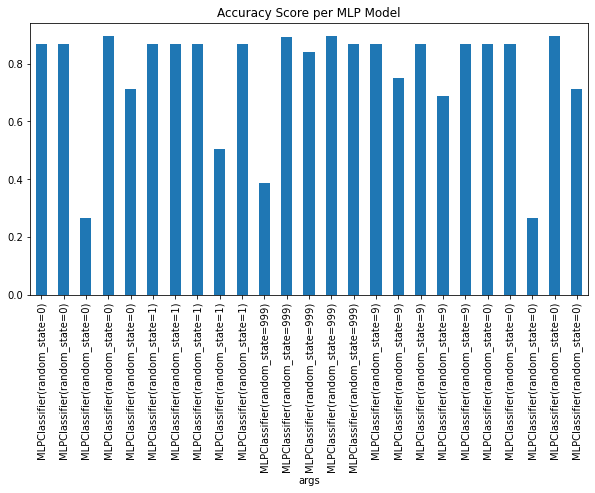

In [ ]:
df_mlp.plot(kind='bar',
            y=['acc'],
            x='args',
            title='Accuracy Score per MLP Model',
            legend=False,
            figsize=(10, 5));

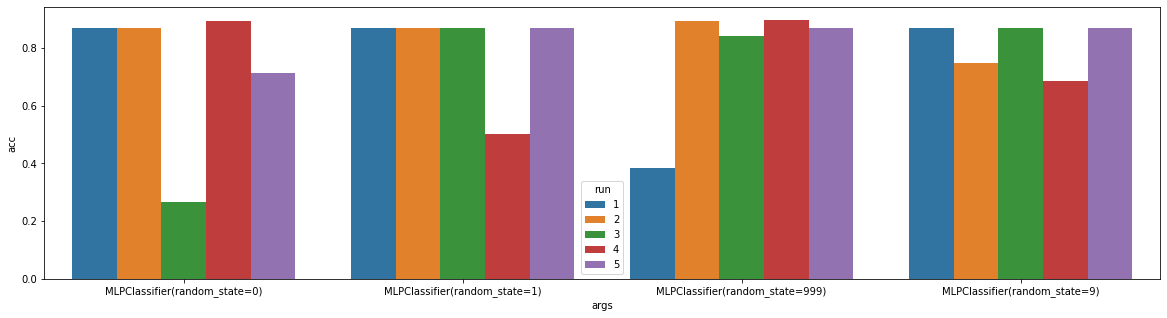

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
_, ax = plt.subplots(figsize=(20, 5))
sns.barplot(ax=ax, x="args", y="acc", data=df_mlp, hue='run');

## Consolidated Analysis

In [ ]:
# Create models df
df_models = pd.concat(df_lst, ignore_index=True)

In [ ]:
# Look at data
df_models

,model,desc,args,encoding,run,acc,f1
0,XGBClassifier,standard_args,XGBClassifier(),label,1,0.935354,0.935354
1,XGBClassifier,standard_args,XGBClassifier(),label,2,0.927273,0.927273
2,XGBClassifier,standard_args,XGBClassifier(),label,3,0.929293,0.929293
3,XGBClassifier,standard_args,XGBClassifier(),label,4,0.925253,0.925253
4,XGBClassifier,standard_args,XGBClassifier(),label,5,0.925253,0.925253
...,...,...,...,...,...,...,...
120,MLPClassifier,standard_args,MLPClassifier(random_state=0),bert,1,0.868687,0.868687
121,MLPClassifier,standard_args,MLPClassifier(random_state=0),bert,2,0.868687,0.868687
122,MLPClassifier,standard_args,MLPClassifier(random_state=0),bert,3,0.266667,0.266667
123,MLPClassifier,standard_args,MLPClassifier(random_state=0),bert,4,0.894949,0.894949


In [ ]:
# Get max acc for each model
df_models.groupby(['model', 'desc']).max()

args  \
model              desc                                                                                                   
LogisticRegression max_iter                                           LogisticRegression(random_state=0, max_iter=1000)   
                   max_iter_elasticnetpenalty_sagasolver_dot5l1ratio  LogisticRegression(random_state=0, max_iter=10...   
                   max_iter_l1penalty_sagasolver                      LogisticRegression(random_state=0, max_iter=10...   
                   max_iter_nopenalty                                 LogisticRegression(random_state=0, max_iter=10...   
                   standard_args                                                     LogisticRegression(random_state=0)   
MLPClassifier      standard_args                                                        MLPClassifier(random_state=999)   
SGDClassifier      standard_args                                      SGDClassifier(loss="hinge", penalty="l2", max_...   
SVC                standard_args                                                                svm.SVC(random_state=0)   
                   standard_args_e5C                                                svm.SVC(random_state=0, C=0.000001)   
                   standard_args_fiveC                                                   svm.SVC(random_state=0, C=0.5)   
                   standard_args_oneC                                                    svm.SVC(random_state=0, C=0.1)   
XGBClassifier      standard_args                                                                        XGBClassifier()   

                                                                     encoding  \
model              desc                                                         
LogisticRegression max_iter                                             label   
                   max_iter_elasticnetpenalty_sagasolver_dot5l1ratio    label   
                   max_iter_l1penalty_sagasolver                        label   
                   max_iter_nopenalty                                    bert   
                   standard_args                                        label   
MLPClassifier      standard_args                                        label   
SGDClassifier      standard_args                                        label   
SVC                standard_args                                        label   
                   standard_args_e5C                                    label   
                   standard_args_fiveC                                  label   
                   standard_args_oneC                                   label   
XGBClassifier      standard_args                                        label   

                                                                      run  \
model              desc                                                     
LogisticRegression max_iter                                             5   
                   max_iter_elasticnetpenalty_sagasolver_dot5l1ratio    5   
                   max_iter_l1penalty_sagasolver                        5   
                   max_iter_nopenalty                                   5   
                   standard_args                                        5   
MLPClassifier      standard_args                                        5   
SGDClassifier      standard_args                                        5   
SVC                standard_args                                        5   
                   standard_args_e5C                                    5   
                   standard_args_fiveC                                  5   
                   standard_args_oneC                                   5   
XGBClassifier      standard_args                                        5   

                                                                           acc  \
model              desc                                                          
LogisticRegres

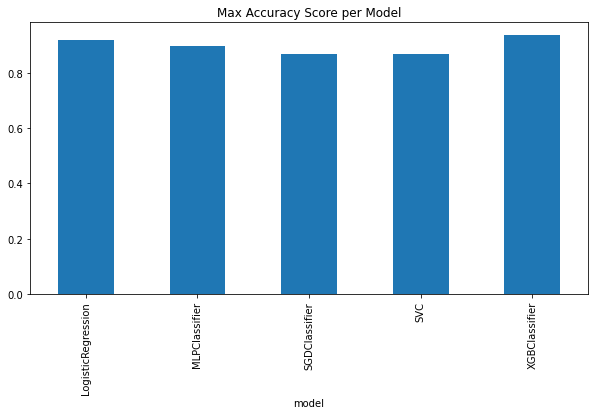

In [ ]:
df_models.groupby(['model']).max().plot(kind='bar',
                                        y=['acc'],
                                        title='Max Accuracy Score per Model',
                                        legend=False,
                                        figsize=(10, 5));

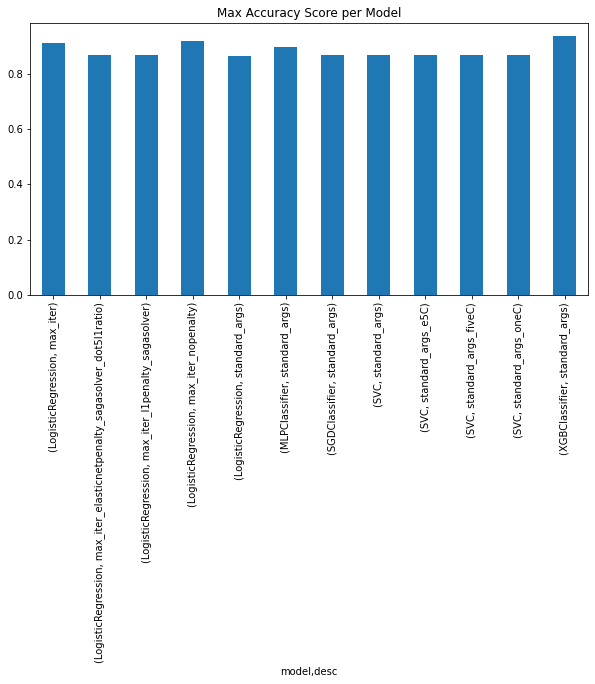

In [ ]:
df_models.groupby(['model', 'desc']).max().plot(kind='bar',
                                                y=['acc'],
                                                title='Max Accuracy Score per Model',
                                                legend=False,
                                                figsize=(10, 5));

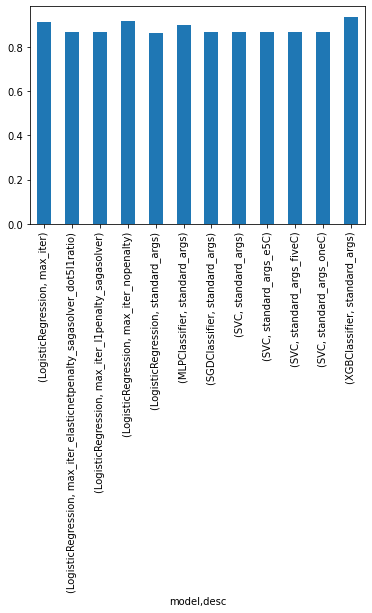

In [ ]:
df_models.groupby(['model', 'desc']).max()['acc'].plot(kind='bar')